## 🩺 TensorFlow Health Check (Run first)
Checks dependencies, file presence, CSV columns, model weights, and a minimal prediction.


In [1]:

# === TF Health Check ===
import os, json, pickle, numpy as np, pandas as pd, importlib

ART_DIR = "tf_artifacts"
MODEL_PATH     = f"{ART_DIR}/intent_classifier.h5"
TOKENIZER_PATH = f"{ART_DIR}/tokenizer.pkl"
ID2LABEL_PATH  = f"{ART_DIR}/id2label.json"
META_PATH      = f"{ART_DIR}/meta.json"
CSV_PATH       = "CustomerSupportTraining.csv"

def ok(msg): print(f"✅ {msg}")
def warn(msg): print(f"⚠️  {msg}")
def err(msg): print(f"❌ {msg}")

print("== 1) Environment ==")
for m in ["pandas","matplotlib","sklearn"]:
    try:
        importlib.import_module(m); ok(f"{m} available")
    except Exception as e:
        err(f"Missing {m}. Install with: pip install {m}")

try:
    import tensorflow as tf
    from tensorflow import keras
    ok(f"TensorFlow available: {tf.__version__}")
except Exception:
    warn("TensorFlow is not available. You can still use the chat without TF.")

print("\n== 2) Files ==")
def show(p, must=False, min_kb=None):
    if not os.path.exists(p):
        (err if must else warn)(f"Missing {p}")
        return None
    sz = os.path.getsize(p); kb = sz/1024
    ok(f"{p} exists, size {kb:.1f} KB")
    if min_kb and kb < min_kb:
        err(f"{p} is too small ({kb:.1f} KB), likely empty or wrong path")
    return sz

show(CSV_PATH, must=True, min_kb=1)
show(MODEL_PATH, min_kb=200)
show(TOKENIZER_PATH, min_kb=10)
show(ID2LABEL_PATH, min_kb=1)
show(META_PATH, min_kb=1)

print("\n== 3) CSV columns ==")
if os.path.exists(CSV_PATH):
    try:
        df = pd.read_csv(CSV_PATH)
        need = {"instruction","intent"}
        if need.issubset(df.columns):
            ok(f"CSV has columns {need}")
        else:
            err(f"CSV columns are {sorted(df.columns)}; must include {sorted(need)}")
    except Exception as e:
        err(f"Failed to read CSV: {e}")

print("\n== 4) Artifacts quick-load ==")
try:
    if os.path.exists(TOKENIZER_PATH):
        with open(TOKENIZER_PATH,"rb") as f:
            tok = pickle.load(f); ok("tokenizer.pkl loaded")
        for w in ["order","refund","payment","cancel","where"]:
            print("   word_index.get(%r) ->" % w, tok.word_index.get(w))
    if os.path.exists(ID2LABEL_PATH):
        with open(ID2LABEL_PATH,"r",encoding="utf-8") as f:
            id2label = json.load(f)
        labels = [id2label[str(i)] if isinstance(id2label, dict) else id2label[i]
                  for i in range(len(id2label))]
        ok(f"id2label loaded: {len(labels)} classes")
    if os.path.exists(META_PATH):
        with open(META_PATH,"r",encoding="utf-8") as f:
            meta = json.load(f); print("   meta:", meta)
except Exception as e:
    err(f"Failed to parse artifacts: {e}")

print("\n== 5) Model weight sanity ==")
try:
    if os.path.exists(MODEL_PATH) and os.path.getsize(MODEL_PATH) > 200*1024:
        from tensorflow import keras
        m = keras.models.load_model(MODEL_PATH, compile=False)
        last = m.layers[-1]; Wb = last.get_weights()
        if not Wb:
            err("Last layer has no weights (empty model)")
        else:
            import numpy as np
            stdW = float(np.std(Wb[0])); print("   last.W.std =", stdW)
            if stdW <= 1e-4: err("Weights variance is too low (likely empty model)")
            else: ok("Weights look normal")
    else:
        warn("No usable model detected (or too small).")
except Exception as e:
    err(f"Failed to load model: {e}")

print("\n== 6) Minimal prediction smoke test ==")
try:
    if os.path.exists(MODEL_PATH) and os.path.getsize(MODEL_PATH) > 200*1024 and os.path.exists(TOKENIZER_PATH):
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        X = pad_sequences(tok.texts_to_sequences([
            "hi",
            "Where is my order 12345?",
            "I need to cancel purchase 1025",
            "I want a refund RM 120 please",
            "what payment options are available",
        ]), maxlen=(meta.get("MAXLEN",64) if os.path.exists(META_PATH) else 64), padding="post", truncating="post")
        P = m.predict(X, verbose=0)
        if P.ndim == 1: P = P[:,None]
        print("   top idx:", P.argmax(axis=1).tolist())
        ok("Smoke test OK")
    else:
        warn("Skipping smoke test (missing model/tokenizer)")
except Exception as e:
    err(f"Smoke test failed: {e}")


== 1) Environment ==
✅ pandas available
✅ matplotlib available
✅ sklearn available
✅ TensorFlow available: 2.20.0

== 2) Files ==
✅ CustomerSupportTraining.csv exists, size 18752.4 KB
✅ tf_artifacts/intent_classifier.h5 exists, size 705.6 KB
✅ tf_artifacts/tokenizer.pkl exists, size 100.8 KB
✅ tf_artifacts/id2label.json exists, size 0.7 KB
❌ tf_artifacts/id2label.json is too small (0.7 KB), likely empty or wrong path
✅ tf_artifacts/meta.json exists, size 0.0 KB
❌ tf_artifacts/meta.json is too small (0.0 KB), likely empty or wrong path

== 3) CSV columns ==
✅ CSV has columns {'intent', 'instruction'}

== 4) Artifacts quick-load ==
✅ tokenizer.pkl loaded
   word_index.get('order') -> 10
   word_index.get('refund') -> 38
   word_index.get('payment') -> 32
   word_index.get('cancel') -> 56
   word_index.get('where') -> 39
✅ id2label loaded: 27 classes
   meta: {'MAXLEN': 64}

== 5) Model weight sanity ==
   last.W.std = 0.3955276906490326
✅ Weights look normal

== 6) Minimal prediction smo

## 🔌 TensorFlow Integration
Loads TF artifacts, predicts intents, evaluates (confusion matrix + report), and can train/export if artifacts are missing.


In [2]:

# === TF Integration ===
import os, json, pickle, numpy as np, pandas as pd, traceback

USE_TF   = True
ART_DIR  = "tf_artifacts"
MODEL_PATH     = f"{ART_DIR}/intent_classifier.h5"
TOKENIZER_PATH = f"{ART_DIR}/tokenizer.pkl"
ID2LABEL_PATH  = f"{ART_DIR}/id2label.json"
META_PATH      = f"{ART_DIR}/meta.json"
CSV_PATH       = "CustomerSupportTraining.csv"
MAXLEN_FALLBACK = 64
TOP_K_VOCAB, EMB_DIM, BATCH, EPOCHS, SEED = 5000, 64, 128, 6, 42

_tf = None; _keras = None; _pad_sequences = None
_loaded = False; _labels = []; _label2id = {}; _tokenizer = None; _model = None; _maxlen = MAXLEN_FALLBACK

def _tf_available():
    global _tf, _keras, _pad_sequences
    if not USE_TF: return False
    try:
        import tensorflow as tf
        from tensorflow import keras
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        _tf = tf; _keras = keras; _pad_sequences = pad_sequences
        return True
    except Exception:
        return False

def _exists_good_model(path):
    return os.path.exists(path) and os.path.getsize(path) > 200_000

def _load_artifacts():
    global _loaded, _labels, _label2id, _tokenizer, _model, _maxlen
    if not _tf_available():
        print("[TF] TensorFlow unavailable — skipping.")
        return False
    try:
        if not _exists_good_model(MODEL_PATH):
            print(f"[TF] Missing/small model: {MODEL_PATH}")
            return False
        _model = _keras.models.load_model(MODEL_PATH, compile=False)
        last = _model.layers[-1]; Wb = last.get_weights()
        if not Wb or np.std(Wb[0]) <= 1e-4:
            print("[TF] Model looks empty (low weight variance).")
            return False

        if not os.path.exists(TOKENIZER_PATH): print("[TF] Missing tokenizer.pkl"); return False
        with open(TOKENIZER_PATH, "rb") as f: _tokenizer = pickle.load(f)

        if not os.path.exists(ID2LABEL_PATH): print("[TF] Missing id2label.json"); return False
        with open(ID2LABEL_PATH, "r", encoding="utf-8") as f: id2label_raw = json.load(f)
        _labels = [id2label_raw[str(i)] if isinstance(id2label_raw, dict) else id2label_raw[i]
                   for i in range(len(id2label_raw))]
        _label2id = {lab:i for i,lab in enumerate(_labels)}

        _maxlen = MAXLEN_FALLBACK
        if os.path.exists(META_PATH):
            try:
                with open(META_PATH, "r", encoding="utf-8") as f: meta = json.load(f)
                if isinstance(meta, dict) and isinstance(meta.get("MAXLEN"), int): _maxlen = meta["MAXLEN"]
            except Exception: pass

        _loaded = True
        print(f"[TF] Artifacts loaded: {len(_labels)} classes, MAXLEN={_maxlen}")
        return True
    except Exception:
        print("[TF] Failed to load artifacts:"); traceback.print_exc()
        _loaded = False; return False

def tf_predict_intent(texts, topk=3):
    if not _loaded:
        if not _load_artifacts(): return None
    seqs = _tokenizer.texts_to_sequences([str(t) for t in texts])
    X = _pad_sequences(seqs, maxlen=_maxlen, padding="post", truncating="post")
    P = _model.predict(X, verbose=0)
    if P.ndim == 1: P = P[:, None]
    out = []
    for probs in P:
        idx = probs.argsort()[-topk:][::-1]
        out.append([( _labels[j], float(probs[j]) ) for j in idx])
    return out

def tf_eval_display(per_class=200):
    if not _loaded:
        if not _load_artifacts():
            print("[TF] Cannot evaluate (artifacts missing/empty)."); return
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    assert os.path.exists(CSV_PATH), f"Missing {CSV_PATH}"
    df = pd.read_csv(CSV_PATH)[["instruction","intent"]].dropna()
    df = df[df["intent"].isin(_labels)]
    parts = []
    for lab in _labels:
        sub = df[df["intent"] == lab]
        if per_class is not None and len(sub) > per_class: sub = sub.sample(per_class, random_state=SEED)
        parts.append(sub)
    eval_df = pd.concat(parts, ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    texts = eval_df["instruction"].astype(str).tolist()
    X = _pad_sequences(_tokenizer.texts_to_sequences(texts), maxlen=_maxlen, padding="post", truncating="post")
    y_true = eval_df["intent"].map(_label2id).values

    P = _model.predict(X, verbose=0)
    if P.ndim == 1: P = P[:, None]
    y_pred = P.argmax(axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(_labels))))
    plt.figure(figsize=(9,7)); plt.imshow(cm, interpolation="nearest"); plt.title("Confusion Matrix")
    plt.colorbar(); ticks = np.arange(len(_labels))
    plt.xticks(ticks, _labels, rotation=65, ha="right"); plt.yticks(ticks, _labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i,j]
            if v != 0: plt.text(j, i, str(v), ha="center", va="center", fontsize=6)
    plt.tight_layout(); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

    print(classification_report(y_true, y_pred, target_names=_labels, digits=4, zero_division=0))
    print("accuracy:", accuracy_score(y_true, y_pred))

def tf_train_and_export(epochs=EPOCHS):
    if not _tf_available():
        print("[TF] TensorFlow unavailable — cannot train."); return False
    os.makedirs(ART_DIR, exist_ok=True)
    assert os.path.exists(CSV_PATH), f"Missing {CSV_PATH}"
    from sklearn.model_selection import train_test_split
    from tensorflow.keras import layers
    from tensorflow.keras.preprocessing.text import Tokenizer

    df = pd.read_csv(CSV_PATH)[["instruction","intent","response"]].dropna()
    labels = sorted(df["intent"].unique().tolist())
    id2label = {i: lab for i, lab in enumerate(labels)}; label2id = {lab:i for i,lab in enumerate(labels)}

    tokenizer = Tokenizer(num_words=TOP_K_VOCAB, oov_token="<OOV>")
    train_df, val_df = train_test_split(df[["instruction","intent"]], test_size=0.15, random_state=SEED, stratify=df["intent"])
    tokenizer.fit_on_texts(train_df["instruction"].astype(str).tolist())
    vocab_size = min(TOP_K_VOCAB, len(tokenizer.word_index) + 1)

    def to_xy(frame):
        seqs = tokenizer.texts_to_sequences(frame["instruction"].astype(str).tolist())
        X = _pad_sequences(seqs, maxlen=MAXLEN_FALLBACK, padding="post", truncating="post")
        y = np.array([label2id[i] for i in frame["intent"]]); return X, y

    X_train, y_train = to_xy(train_df); X_val, y_val = to_xy(val_df)
    num_classes = len(labels)
    model = _keras.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM, input_length=MAXLEN_FALLBACK),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    cb = [_keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_accuracy")]
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=BATCH, verbose=1, callbacks=cb)

    model.save(MODEL_PATH, include_optimizer=False)
    with open(TOKENIZER_PATH, "wb") as f: pickle.dump(tokenizer, f)
    with open(ID2LABEL_PATH, "w", encoding="utf-8") as f: json.dump(id2label, f, ensure_ascii=False, indent=2)
    with open(META_PATH, "w", encoding="utf-8") as f: json.dump({"MAXLEN": int(MAXLEN_FALLBACK)}, f, ensure_ascii=False, indent=2)

    size_mb = os.path.getsize(MODEL_PATH)/1024/1024
    last = model.layers[-1]; Wb = last.get_weights()
    stdW = float(np.std(Wb[0])) if Wb else 0.0
    print(f"[TF] Exported: size={size_mb:.2f}MB  last.W.std={stdW:.5f}")
    print("[TF] Training + export done."); return True

print("[TF] Integration ready: tf_train_and_export(), tf_eval_display(), tf_predict_intent()")


[TF] Integration ready: tf_train_and_export(), tf_eval_display(), tf_predict_intent()


## 🚀 Auto-train & Export (runs once to create artifacts)
If artifacts are missing, run this cell. It will train a lightweight model on `CustomerSupportTraining.csv` and save the 4 artifacts to `tf_artifacts/`.


In [3]:
tf_train_and_export(epochs=6)

Epoch 1/6


C:\Users\Linmu\anaconda3\envs\AIPython3.10\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1312 - loss: 3.2253 - val_accuracy: 0.4257 - val_loss: 2.9857
Epoch 2/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3904 - loss: 2.3643 - val_accuracy: 0.6904 - val_loss: 1.6797
Epoch 3/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6178 - loss: 1.3954 - val_accuracy: 0.8663 - val_loss: 0.9618
Epoch 4/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7545 - loss: 0.8947 - val_accuracy: 0.9018 - val_loss: 0.6033
Epoch 5/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8344 - loss: 0.6191 - val_accuracy: 0.9290 - val_loss: 0.4311
Epoch 6/6
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8839 - loss: 0.4578 - val_accuracy: 0.9459 - val_loss: 0.3001


[TF] Exported: size=0.69MB  last.W.std=0.39497
[TF] Training + export done.


True

## 📊 Evaluation (Confusion Matrix + Classification Report)
After training/export, run this to see metrics.


[TF] Artifacts loaded: 27 classes, MAXLEN=64


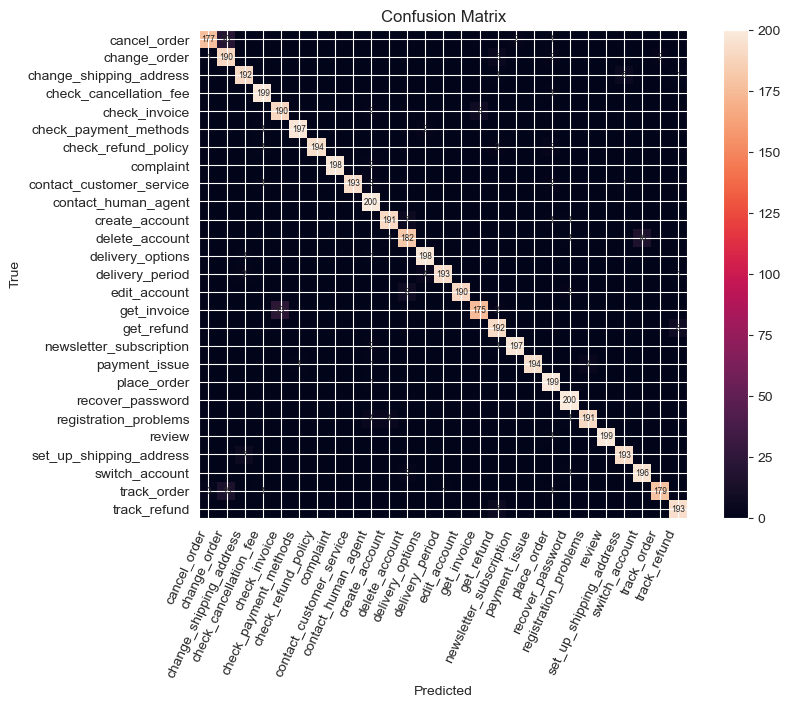

                          precision    recall  f1-score   support

            cancel_order     0.9779    0.8850    0.9291       200
            change_order     0.8444    0.9500    0.8941       200
 change_shipping_address     0.9505    0.9600    0.9552       200
  check_cancellation_fee     0.9803    0.9950    0.9876       200
           check_invoice     0.8920    0.9500    0.9201       200
   check_payment_methods     0.9949    0.9850    0.9899       200
     check_refund_policy     1.0000    0.9700    0.9848       200
               complaint     1.0000    0.9900    0.9950       200
contact_customer_service     1.0000    0.9650    0.9822       200
     contact_human_agent     0.9259    1.0000    0.9615       200
          create_account     0.9745    0.9550    0.9646       200
          delete_account     0.9100    0.9100    0.9100       200
        delivery_options     0.9706    0.9900    0.9802       200
         delivery_period     0.9948    0.9650    0.9797       200
         

In [27]:
tf_eval_display(per_class=200)


# 💬 TensorFlow Chat UI (Tkinter) — **Patched Notebook**
This version includes:
- **Enhanced fast-path matching** (exact → contains → fuzzy similarity)
- **Lower prediction threshold** (default 0.40) and configurable **MAXLEN**
- Optional **debug tags** showing `[intent:confidence]`
- A helper cell to **list all intents and sample patterns**


In [4]:

# === Paths (edit if needed) ===
import os
BASE_DIR = os.path.dirname(os.path.abspath("__file__")) if '__file__' in globals() else os.getcwd()

PATH_INTENTS_JSON = os.path.join(BASE_DIR, "intents.json")
PATH_ID2LABEL     = os.path.join(BASE_DIR, "id2label.json")
PATH_CSV          = os.path.join(BASE_DIR, "CustomerSupportTraining.csv")  # optional

PATH_TOKENIZER    = os.path.join(BASE_DIR, "tokenizer.pkl")
PATH_TF_MODEL     = os.path.join(BASE_DIR, "intent_classifier.h5")

print("Notebook cwd:", BASE_DIR)
for p in [PATH_INTENTS_JSON, PATH_ID2LABEL, PATH_CSV, PATH_TOKENIZER, PATH_TF_MODEL]:
    print(("✔" if os.path.exists(p) else "✘"), p)


Notebook cwd: C:\Users\Linmu\Downloads\AI_LinMunLok_G12
✔ C:\Users\Linmu\Downloads\AI_LinMunLok_G12\intents.json
✔ C:\Users\Linmu\Downloads\AI_LinMunLok_G12\id2label.json
✔ C:\Users\Linmu\Downloads\AI_LinMunLok_G12\CustomerSupportTraining.csv
✔ C:\Users\Linmu\Downloads\AI_LinMunLok_G12\tokenizer.pkl
✔ C:\Users\Linmu\Downloads\AI_LinMunLok_G12\intent_classifier.h5


In [5]:

# === Imports ===
import json, re, random, pickle, threading
from datetime import datetime
from difflib import SequenceMatcher

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tkinter as tk
from tkinter import Frame, Label, Button

# %gui tk  # uncomment if your environment needs it


In [6]:

# === Load resources ===
with open(PATH_INTENTS_JSON, "r", encoding="utf-8") as f:
    intents_data = json.load(f)

with open(PATH_ID2LABEL, "r", encoding="utf-8") as f:
    id2label = json.load(f)
label2id = {v: int(k) for k, v in id2label.items()}

intent_to_response = {}
intent_groups = {}
if os.path.exists(PATH_CSV):
    df = pd.read_csv(PATH_CSV)
    if {"intent","response"}.issubset(df.columns):
        for intent, g in df.groupby("intent"):
            g = g.copy().reset_index(drop=True)
            intent_groups[intent] = g
            resp_series = g["response"].astype(str)
            if len(resp_series) > 0:
                longest_idx = resp_series.str.len().idxmax()
                intent_to_response[intent] = resp_series.loc[longest_idx]

with open(PATH_TOKENIZER, "rb") as f:
    tokenizer = pickle.load(f)

model = keras.models.load_model(PATH_TF_MODEL, compile=False)

print("Loaded resources OK.")


Loaded resources OK.


In [7]:

# === Runtime config ===
THRESHOLD = 0.40   # was 0.60
MAXLEN    = 30     # change to your training value if different
SHOW_DEBUG = True  # show [intent:conf] at end of reply

# === Helper functions ===
def normalize_text(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def text_to_seq(text: str, maxlen: int = MAXLEN):
    seq = tokenizer.texts_to_sequences([text])
    return pad_sequences(seq, maxlen=maxlen, padding="post", truncating="post")

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1, keepdims=True)

PLACEHOLDER_ALIASES = {
    "order number": "Order Number",
    "tracking number": "Tracking Number",
    "invoice number": "Invoice Number",
    "online company portal info": "Online Company Portal Info",
    "online order interaction": "Online Order Interaction",
    "customer support hours": "Customer Support Hours",
    "customer support phone number": "Customer Support Phone Number",
    "website url": "Website URL",
    "company name": "Company Name",
    "account type": "Account Type",
    "account category": "Account Category",
    "money amount": "Money Amount",
    "refund amount": "Refund Amount",
    "contact method": "Contact Method",
}

def normalize_placeholders(text: str) -> str:
    def repl(m):
        inner = m.group(1).strip()
        canon = PLACEHOLDER_ALIASES.get(inner.casefold(), inner)
        return "{{" + canon + "}}"
    return re.sub(r"\{\{\s*([^}]+?)\s*\}\}", repl, text)

def choose_json_response_for_intent(intent: str):
    info = intents_data.get("intents", {}).get(intent, {})
    resps = info.get("responses", [])
    if resps:
        return random.choice(resps)
    return None

def choose_csv_response_for_intent(intent: str):
    return intent_to_response.get(intent)

def fill_placeholders(response_template: str, user_input: str, intent: str) -> str:
    if not response_template:
        return ""
    response_template = normalize_placeholders(response_template)

    intent_info = intents_data.get("intents", {}).get(intent, {})
    intent_placeholder_rules = intent_info.get("placeholders", {})

    for name, pattern in intent_placeholder_rules.items():
        m = re.search(pattern, user_input, flags=re.IGNORECASE)
        if m:
            value = m.group(0)
            response_template = re.sub(
                r"\{\{\s*" + re.escape(name) + r"\s*\}\}",
                value,
                response_template,
                flags=re.IGNORECASE,
            )

    global_ph = intents_data.get("placeholders", {})
    for placeholder, options in global_ph.items():
        if placeholder not in response_template:
            continue

        replacement = None
        if options and options[0] != "<dynamic>":
            replacement = random.choice(options)
        else:
            if placeholder == "{{Order Number}}":
                m = re.search(r"\b\d{3,}\b", user_input)
            elif placeholder == "{{Tracking Number}}":
                m = re.search(r"\b[A-Z0-9]{8,}\b", user_input)
            elif placeholder == "{{Invoice Number}}":
                m = re.search(r"\b\d{5,}\b", user_input)
            elif placeholder in ["{{Refund Amount}}", "{{Money Amount}}"]:
                m = re.search(r"(RM\s?\d+(?:\.\d{1,2})?|\d+(?:\.\d{1,2})?\s?(?:USD|MYR|dollars))", user_input, re.IGNORECASE)
            elif placeholder == "{{Account Type}}":
                m = re.search(r"\b(saving|current|premium)\b", user_input, re.IGNORECASE)
            elif placeholder == "{{Account Category}}":
                m = re.search(r"\b(personal|business|corporate)\b", user_input, re.IGNORECASE)
            else:
                m = None
            replacement = m.group(0) if m else "<dynamic>"
        response_template = response_template.replace(placeholder, replacement)
    return response_template


In [8]:

def _similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def fastpath_response(user_input_lower: str):
    intents = intents_data.get("intents", {})
    # 1) exact
    for intent_name, info in intents.items():
        for p in info.get("patterns", []):
            if p.lower() == user_input_lower:
                r = choose_json_response_for_intent(intent_name) or choose_csv_response_for_intent(intent_name)
                return fill_placeholders(r, user_input_lower, intent_name) if r else None
    # 2) contains
    for intent_name, info in intents.items():
        for p in info.get("patterns", []):
            pl = p.lower().strip()
            if len(pl) >= 4 and pl in user_input_lower:
                r = choose_json_response_for_intent(intent_name) or choose_csv_response_for_intent(intent_name)
                return fill_placeholders(r, user_input_lower, intent_name) if r else None
    # 3) fuzzy
    best = (0.0, None)
    for intent_name, info in intents.items():
        for p in info.get("patterns", []):
            score = _similar(user_input_lower, p.lower())
            if score > best[0]:
                best = (score, intent_name)
    if best[0] >= 0.80:
        intent_name = best[1]
        r = choose_json_response_for_intent(intent_name) or choose_csv_response_for_intent(intent_name)
        return fill_placeholders(r, user_input_lower, intent_name) if r else None
    return None

def predict_intent_tf(text: str, threshold: float = None):
    threshold = THRESHOLD if threshold is None else threshold
    text = normalize_text(text)
    x = text_to_seq(text, maxlen=MAXLEN)
    logits = model.predict(x, verbose=0)
    if logits.ndim == 1:
        probs = softmax(logits)
    else:
        probs = softmax(logits[0])
    idx = int(np.argmax(probs))
    conf = float(probs[idx])
    intent = id2label.get(str(idx))
    if intent is None or conf < threshold:
        return None, conf
    return intent, conf

def get_bot_response(user_input: str) -> str:
    ui = (user_input or "").strip()
    if not ui:
        return "Could you provide a bit more detail?"

    lower = ui.lower()

    fp = fastpath_response(lower)
    if fp:
        return fp

    if len(lower) < 2:
        return "Could you provide a bit more detail?"

    intent, conf = predict_intent_tf(ui)
    if intent is None:
        return "Sorry, I didn’t quite understand that. Could you rephrase?"

    resp = choose_json_response_for_intent(intent) or choose_csv_response_for_intent(intent)
    if not resp:
        return f"I detected intent '{intent}' (confidence {conf:.2f}), but I don't have a response template yet."

    final = fill_placeholders(resp, ui, intent)
    if SHOW_DEBUG:
        final += f"  [{intent}:{conf:.2f}]"
    return final


In [9]:

# === List all intents and sample patterns ===
intents = intents_data.get("intents", {})
for name, info in intents.items():
    pats = info.get("patterns", [])
    print(f"- {name} -> examples: " + "; ".join(pats[:5]))


- greeting -> examples: hi; hello; hey; good morning; good afternoon
- exit -> examples: quit; q; bye; exit; goodbye
- place_order -> examples: I want to place an order; Can you help me order; Order product; Buy item


In [10]:
import re, difflib, random

# ---------- fuzzy match helpers (no external deps) ----------
def _norm_text_for_match(s: str) -> str:
    s = (s or "").lower()
    s = re.sub(r"\b\d{3,}\b", "__PH__", s)           # normalize numbers
    s = re.sub(r"\{\{[^}]+?\}\}", "__PH__", s)       # normalize placeholders
    s = re.sub(r"[^a-z0-9_ ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _jaccard(a_tokens, b_tokens):
    a, b = set(a_tokens), set(b_tokens)
    if not a and not b: return 1.0
    return len(a & b) / max(1, len(a | b))

def _tokenize(s: str):
    return [t for t in s.split() if t]

def _similarity(a: str, b: str) -> float:
    # hybrid score: average of SequenceMatcher ratio and Jaccard
    a_n, b_n = _norm_text_for_match(a), _norm_text_for_match(b)
    sm = difflib.SequenceMatcher(None, a_n, b_n).ratio()         # 0..1
    jac = _jaccard(_tokenize(a_n), _tokenize(b_n))                # 0..1
    return (sm + jac) / 2.0

def fuzzy_intent_by_instructions(user_input: str, min_score: int = 72):
    """
    Compare user_input with CSV 'instruction' texts.
    Requires a global 'intent_groups' like: {intent: DataFrame with 'instruction' column}
    Returns (intent, score[0..100]) or (None, score)
    """
    if not intent_groups:
        return (None, 0)
    user_norm = _norm_text_for_match(user_input or "")
    best_intent, best_score = None, -1.0
    for intent, grp in intent_groups.items():
        local_best = -1.0
        for inst in grp["instruction"].fillna("").astype(str):
            score = _similarity(user_norm, inst)
            if score > local_best:
                local_best = score
        if local_best > best_score:
            best_score, best_intent = local_best, intent
    pct = int(round(best_score * 100))
    return (best_intent, pct) if pct >= min_score else (None, pct)

# ---------- enrich placeholders (TOP-LEVEL; not nested) ----------
# If these helpers already exist in your codebase, keep them; otherwise define minimal versions:
if "_extract_person_name" not in globals():
    _person_pat  = re.compile(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,3})\b")
    def _extract_person_name(s: str):
        m = _person_pat.search(s or "")
        return m.group(1) if m else None

if "_normalize_amount" not in globals():
    _amount_pat  = re.compile(r"(?i)(?:rm\s*)?\b\d+(?:\.\d{1,2})?\b")
    def _normalize_amount(token: str) -> str:
        if not token: return token
        if re.match(r"(?i)^rm\s*\d", token):
            return re.sub(r"(?i)^rm\s*", "RM ", token)
        return "RM " + re.sub(r"(?i)^rm\s*", "", token)

if "_guess_account_type" not in globals():
    def _guess_account_type(s: str) -> str:
        s = (s or "").lower()
        if any(k in s for k in ["savings account","saving account","savings","saving"]):
            return "Savings"
        if any(k in s for k in ["current account","checking"]):
            return "Current"
        return "Account"

def _auto_enrich_placeholders(template: str, user_input: str, intent: str) -> str:
    """Use your existing fill_placeholders first; then enrich with person/amount/account."""
    if not isinstance(template, str):
        return template
    # 1) your existing filler if available
    try:
        base = fill_placeholders(template, user_input, intent)
    except Exception:
        base = template
    out = base

    # 2) Person Name
    pname = _extract_person_name(user_input)
    if pname:
        out = out.replace("{{Person Name}}", pname)

    # 3) Amount
    m_amt = re.search(r"(?i)(?:rm\s*)?\b\d+(?:\.\d{1,2})?\b", user_input or "")
    if m_amt:
        norm = _normalize_amount(m_amt.group(0))
        for key in ("{{Money Amount}}","{{Refund Amount}}","{amount}","{{Amount}}"):
            out = out.replace(key, norm)

    # 4) Account type/category
    acct = _guess_account_type(user_input)
    out = out.replace("{{Account Type}}", acct).replace("{{Account Category}}", acct)

    # 5) soften common portal placeholders to avoid leaking raw tokens
    out = out.replace("{{Order Status}}","Order Status").replace("{{Online Order Interaction}}","Manage Order")
    out = out.replace("{{Online Company Portal Info}}","Account Portal")
    return out

# ---------- final router (rules → ML → fuzzy → BART → fallback) ----------
def get_bot_response(user_input: str) -> str:
    t = user_input.lower().strip()

    # greetings / exit (keep your fast paths if you have greeting_responses/exit_responses)
    try:
        if any(g in t for g in [
            "hi","hello","hey","good morning","good afternoon","good evening",
            "hiya","yo","sup","what's up","howdy","greetings","morning","afternoon","evening"
        ]):
            return random.choice(greeting_responses)
        if any(g in t for g in [
            "quit","q","bye","exit","goodbye","see you","see ya","later",
            "talk to you later","take care","farewell","catch you later","close"
        ]):
            return random.choice(exit_responses)
    except Exception:
        pass

    # 0) short text
    if len(t) < 10:
        return "Could you provide a bit more detail?"

    # 1) exact pattern from intents.json (if you keep intents_data/intent_to_response)
    try:
        for intent_name, intent_info in intents_data["intents"].items():
            for p in intent_info.get("patterns", []):
                if p.lower() == t:
                    tmpl = choose_best_response_for_intent(intent_name, user_input) or \
                           (intent_to_response.get(intent_name) if "intent_to_response" in globals() else None)
                    return _auto_enrich_placeholders(tmpl, user_input, intent_name) if tmpl else \
                           "Sorry, I don’t understand your request."
    except Exception:
        pass

    # 2) rule-based routing (make sure you have rules_to_intent defined elsewhere)
    try:
        rule_int = rules_to_intent(user_input)
        if rule_int:
            tmpl = choose_best_response_for_intent(rule_int, user_input)
            if tmpl:
                return _auto_enrich_placeholders(tmpl, user_input, rule_int)
    except Exception:
        pass

    # 3) ML prediction (predict_intent must be defined in your code)
    try:
        intent, conf = predict_intent(user_input)
        if intent and conf >= 0.70:
            tmpl = choose_best_response_for_intent(intent, user_input)
            if tmpl:
                return _auto_enrich_placeholders(tmpl, user_input, intent)
    except Exception:
        pass

    # 4) Fuzzy search over CSV instructions to guess intent when ML is low-confidence
    try:
        f_int, f_score = fuzzy_intent_by_instructions(user_input, min_score=72)
        if f_int:
            tmpl = choose_best_response_for_intent(f_int, user_input)
            if tmpl:
                return _auto_enrich_placeholders(tmpl, user_input, f_int)
    except Exception:
        pass

    # 5) BART generator fallback (if you have bart_* objects defined)
    try:
        enc = bart_tokenizer([user_input], return_tensors="pt", truncation=True, padding=True, max_length=256)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            gen_ids = bart_model.generate(**enc, max_length=200, num_beams=4, early_stopping=True)
        cand = bart_tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        return cand
    except Exception:
        pass

    # 6) last resort
    return "Sorry, I didn’t quite understand that. Could you rephrase?"

In [11]:
import re, random

# --- helpers ---
_MONTHS = r"(January|February|March|April|May|June|July|August|September|October|November|December|Jan|Feb|Mar|Apr|Jun|Jul|Aug|Sept|Sep|Oct|Nov|Dec)"
_person_pat = re.compile(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,3})\b")

def _extract_person_name(s: str):
    m = _person_pat.search(s or "")
    return m.group(1) if m else ""

def _last_name(full: str):
    return (full.split()[0] if full else "")

def _normalize_amount(tok: str, prefer_rm=True) -> str:
    if not tok: return ""
    tok = tok.strip()
    # Accept "RM120", "RM 120.80", "$120.80", "120.80"
    m = re.search(r"(?i)^(rm|\$)?\s*(\d+(?:\.\d{1,2})?)$", tok)
    if not m:
        # Try to find inside sentence
        m = re.search(r"(?i)(rm|\$)?\s*(\d+(?:\.\d{1,2})?)", tok)
    if not m: return tok
    cur, num = m.group(1), m.group(2)
    if cur and cur.strip().lower().startswith("rm"):
        return f"RM {num}"
    if cur == "$":
        return f"${num}"
    # no currency symbol -> choose
    return f"RM {num}" if prefer_rm else f"${num}"

def _find_amount(s: str):
    m = re.search(r"(?i)(rm|\$)?\s*\d+(?:\.\d{1,2})?", s or "")
    return _normalize_amount(m.group(0)) if m else ""

def _find_date_or_range(s: str):
    txt = s or ""
    # Range like: 1–30 Nov 2024 / 1-30 November 2024
    m = re.search(rf"\b(\d{{1,2}})\s*[-–]\s*(\d{{1,2}})\s+{_MONTHS}\s+(\d{{4}})\b", txt, flags=re.IGNORECASE)
    if m:
        d1, d2, mon, year = m.group(1), m.group(2), m.group(3), m.group(4)
        mon = mon  # keep original label
        return f"{d1}–{d2} {mon} {year}"
    # Month + year: November 2024 / Nov 2024
    m = re.search(rf"\b{_MONTHS}\s+\d{{4}}\b", txt, flags=re.IGNORECASE)
    if m:
        return m.group(0)
    return ""

def _find_invoice_number(s: str):
    # explicit: invoice number/no/# 12345
    m = re.search(r"(?i)invoice\s*(?:no\.?|number)?\s*#?\s*(\d{3,})", s or "")
    if m: return m.group(1)
    # fallback: if 'invoice' present, any 3+ digits
    if re.search(r"(?i)\binvoice\b", s or ""):
        m2 = re.search(r"\b(\d{3,})\b", s or "")
        if m2: return m2.group(1)
    return ""

def _find_order_number(s: str):
    m = re.search(r"(?i)(order|purchase)\s*(?:no\.?|number|#)?\s*#?\s*(\d{3,})", s or "")
    return m.group(2) if m else (re.search(r"\b(\d{3,})\b", s or "") or (None,))[0] or ""

def _guess_account_type(s: str):
    t = (s or "").lower()
    if any(k in t for k in ["savings account","saving account","savings","saving"]): return "Savings"
    if any(k in t for k in ["current account","checking"]): return "Current"
    return "Account"

def _company_placeholder_map():
    # Use intents_data.placeholders if available; else defaults
    mapping = {
        "{{Customer Support Email}}": "support@example.com",
        "{{Customer Support Phone Number}}": "+60-987-654-321",
        "{{Customer Support Hours}}": "Mon–Fri, 9 AM – 6 PM",
        "{{Website URL}}": "https://www.example.com",
        "{{Online Company Portal Info}}": "Account Portal",
        "{{Online Order Interaction}}": "Manage Order",
        "{{Order Status}}": "Order Status",
    }
    try:
        ph = (intents_data or {}).get("placeholders", {})
        def pick(key, default):
            v = ph.get(key)
            if isinstance(v, list) and v:
                return random.choice(v)
            return default
        for k in list(mapping.keys()):
            mapping[k] = pick(k, mapping[k])
    except Exception:
        pass
    return mapping

def _cleanup(text: str):
    out = str(text)
    out = re.sub(r"<\s*dynamic\s*>", "", out)
    out = re.sub(r"\s*#\s*(?=[\.\,\;\)]|$)", "", out)  # remove trailing lone '#'
    out = re.sub(r"\s{2,}", " ", out).strip()
    # remove any leftover placeholders {{...}}
    out = re.sub(r"\{\{[^}]+}}", "", out)
    return out

# --- main filler (compatible with both 2-arg and 3-arg calls) ---
def fill_placeholders(template: str, user_input: str, intent: str = None) -> str:
    person_name = _extract_person_name(user_input)
    last_name   = _last_name(person_name)
    amount      = _find_amount(user_input)
    date_range  = _find_date_or_range(user_input)
    inv_no      = _find_invoice_number(user_input)
    order_no    = _find_order_number(user_input)
    acct_type   = _guess_account_type(user_input)

    # salutation: if we have a last name, use "Mr./Ms." heuristic (keep simple: default Mr.)
    salutation  = "Mr." if last_name else ""

    repl = {
        "{{Salutation}}": salutation,
        "{{Client Last Name}}": last_name,
        "{{Person Name}}": person_name,
        "{{Date Range}}": date_range,
        "{{Amount}}": amount,
        "{{Money Amount}}": amount,
        "{{Refund Amount}}": amount,
        "{{Invoice Number}}": inv_no,
        "{{Order Number}}": order_no,
        "{{Account Type}}": acct_type,
        "{{Account Category}}": acct_type,
        # some templates use these curly styles
        "{amount}": amount,
        "{order_number}": order_no,
        "{invoice_number}": inv_no,
    }

    # company-level placeholders
    for k, v in _company_placeholder_map().items():
        repl[k] = v

    # apply replacements
    result = str(template)
    for k, v in repl.items():
        result = result.replace(k, v)

    # If there is still "invoice number <dynamic>" without number but we have a person name → rephrase
    if not inv_no and person_name:
        result = re.sub(r"(?i)invoice\s*number\s*#?\s*<\s*dynamic\s*>", f"invoice for {person_name}", result)

    # Final cleanup
    return _cleanup(result)

In [12]:
import os, re, json, random
import pandas as pd
from string import punctuation

INTENTS_JSON = "intents.json"
CSV_PATH     = "CustomerSupportTraining.csv"

# ---------- utils ----------
def _norm(s: str) -> str:
    s = str(s).lower().strip()
    tbl = str.maketrans({ch: " " for ch in punctuation})
    s = s.translate(tbl)
    s = re.sub(r"\s+", " ", s)
    return s

_order_num_re = re.compile(r"\b\d{3,}\b")
_amount_re    = re.compile(r"(?i)(?:rm\s*)?\b\d+(?:\.\d{1,2})?\b")

# ---------- load hi/bye from your intents.json structure ----------
def _load_hi_bye_from_json(path=INTENTS_JSON):
    greet_resps, exit_resps = [], []
    greet_set = {"hi","hello","hey","good morning","good afternoon","good evening"}
    exit_set  = {"bye","goodbye","see you","exit","quit","q"}
    try:
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)
            intents = data.get("intents", {})
            if isinstance(intents, dict):
                if "greeting" in intents:
                    greet_resps = list(intents["greeting"].get("responses", []) or [])
                    for p in intents["greeting"].get("patterns", []) or []:
                        greet_set.add(_norm(p))
                if "exit" in intents:
                    exit_resps  = list(intents["exit"].get("responses", []) or [])
                    for p in intents["exit"].get("patterns", []) or []:
                        exit_set.add(_norm(p))
    except Exception:
        pass
    return greet_resps, exit_resps, greet_set, exit_set

_GREET_RS, _EXIT_RS, _GREET_SET, _EXIT_SET = _load_hi_bye_from_json()

def _pick(arr, default_text):
    arr = [str(x).strip() for x in (arr or []) if str(x).strip()]
    return (random.choice(arr) if arr else default_text)

def hi_bye_fastpath(user_text: str):
    t = _norm(user_text)
    if t in _GREET_SET:
        return _pick(_GREET_RS, "Hello! How can I help you today?")
    if t in _EXIT_SET:
        return _pick(_EXIT_RS, "Goodbye! Have a great day.")
    return None

# ---------- CSV knowledge base (intent -> list of responses) ----------
def load_csv_kb(path=CSV_PATH):
    if not os.path.exists(path):
        print(f"[router] CSV not found at {path}. CSV_KB disabled.")
        return {}
    df = pd.read_csv(path)
    need = {"instruction","intent","response"}
    if not need.issubset(df.columns):
        print(f"[router] CSV lacks columns {need}. CSV_KB disabled.")
        return {}
    df = df[list(need)].dropna()
    kb = {}
    for intent, g in df.groupby("intent"):
        kb[intent] = g["response"].astype(str).tolist()
    print(f"[router] CSV_KB loaded: {len(kb)} intents, {len(df)} rows")
    return kb

if "CSV_KB" not in globals() or not isinstance(globals()["CSV_KB"], dict):
    CSV_KB = load_csv_kb()

# ---------- chooser wrapper: prefer your original chooser, fallback to CSV ----------
try:
    _BASE_CHOOSER = choose_best_response_for_intent
except NameError:
    _BASE_CHOOSER = None
    print("[router] WARNING: original choose_best_response_for_intent not found; using CSV only.")

def choose_best_response_for_intent(intent_name, user_text):
    resp = None
    if _BASE_CHOOSER:
        try:
            resp = _BASE_CHOOSER(intent_name, user_text)
        except Exception:
            resp = None
    if resp:
        return resp
    cands = CSV_KB.get(intent_name)
    if cands:
        return random.choice(cands)
    # allow a legacy dict like intent_to_response
    if "intent_to_response" in globals():
        return globals()["intent_to_response"].get(intent_name)
    return None

# ---------- small rule router ----------
def rules_to_intent(user_text: str):
    t = _norm(user_text)
    if "cancel" in t and ("purchase" in t or "order" in t):
        return "cancel_order"
    if (("order" in t) and any(k in t for k in ("where","status","track","check"))) or _order_num_re.search(t):
        if "place" not in t and "buy" not in t and ("purchase" not in t or "cancel" in t):
            return "track_order"
    if "refund" in t:
        return "get_refund"
    if "payment" in t and any(k in t for k in ("option","options","method","methods")):
        return "check_payment_methods"
    return None

# ---------- placeholder autofill (used only if your own fill_placeholders fails) ----------
def _auto_fill_placeholders(text: str, user_input: str, intent_name: str):
    """Use your own fill_placeholders if present; otherwise do a minimal autofill."""
    if not isinstance(text, str):
        return text
    out = text

    # Order number
    m = _order_num_re.search(user_input or "")
    if m:
        order_no = m.group(0)
        out = out.replace("{{Order Number}}", order_no).replace("{order_number}", order_no)

    # Amount (normalize to "RM 123.45")
    m2 = _amount_re.search(user_input or "")
    if m2:
        amt = m2.group(0)
        if not re.match(r"(?i)^rm\s*\d", amt):
            # e.g., "120"  → "RM 120"
            cleaned = re.sub(r"(?i)^rm\s*", "", amt)  # remove any stray "rm"
            norm = "RM " + cleaned
        else:
            # e.g., "rm120" → "RM 120"
            norm = re.sub(r"(?i)^rm\s*", "RM ", amt)
        out = out.replace("{{Amount}}", norm).replace("{amount}", norm)

    # Soften common portal placeholders to avoid leaking raw tokens
    out = out.replace("{{Order Status}}", "Order Status").replace("{{Online Order Interaction}}", "Manage Order")
    out = out.replace("{{Online Company Portal Info}}", "Account Portal")
    return out

# ---------- SAFE wrapper install (idempotent; avoids recursion) ----------
def _is_ours(f): return getattr(f, "__name__", "") == "get_bot_response_router_wrapper"
if "__BASE_GET_BOT_RESPONSE__" not in globals():
    globals()["__BASE_GET_BOT_RESPONSE__"] = globals().get("get_bot_response", None)

def get_bot_response_router_wrapper(user_input, *args, **kwargs):
    # 0) hi/bye guaranteed
    hb = hi_bye_fastpath(user_input)
    if hb: return hb

    # 1) rules → intent → template
    intent = rules_to_intent(user_input)
    if intent:
        tmpl = choose_best_response_for_intent(intent, user_input)
        if tmpl:
            if "fill_placeholders" in globals():
                try:
                    return fill_placeholders(tmpl, user_input, intent)
                except Exception:
                    pass
            return _auto_fill_placeholders(tmpl, user_input, intent)

    # 2) optional TF high-confidence route (if you enabled TF earlier)
    if "tf_predict_intent" in globals() and "choose_template_for_intent" in globals():
        try:
            preds = tf_predict_intent([user_input], topk=1)
            if preds:
                lab, prob = preds[0][0]
                if prob >= 0.70:
                    tmpl = choose_template_for_intent(lab) if "choose_template_for_intent" in globals() else choose_best_response_for_intent(lab, user_input)
                    if tmpl:
                        if "fill_placeholders" in globals():
                            try:
                                return fill_placeholders(tmpl, user_input, lab)
                            except Exception:
                                pass
                        return _auto_fill_placeholders(tmpl, user_input, lab)
        except Exception:
            pass

    # 3) fallback to the base get_bot_response (never call ourselves)
    base = globals().get("__BASE_GET_BOT_RESPONSE__", None)
    if base and not _is_ours(base):
        return base(user_input, *args, **kwargs)

    # 4) last resort
    return "Sorry, I didn’t quite understand that. Could you rephrase?"

if not _is_ours(globals().get("get_bot_response", None)):
    globals()["get_bot_response"] = get_bot_response_router_wrapper
    print("[router] Installed unified router (hi/bye + rules + CSV + safe fallback).")
else:
    print("[router] Router already installed (skipped).")

[router] CSV_KB loaded: 27 intents, 26872 rows
[router] WARNING: original choose_best_response_for_intent not found; using CSV only.
[router] Installed unified router (hi/bye + rules + CSV + safe fallback).


In [13]:

# === Quick test ===
tests = [
    "hi",
    "Where is my order 12345?",
    "I want a refund RM 120 please",
    "I'm trying to check what payment options are available",
]
for t in tests:
    print(t, "->", get_bot_response(t))


hi -> Hello! What can I do for you today?
Where is my order 12345? -> Thank you for reaching out! I'm here to assist you with checking the estimated time of arrival (ETA) for your purchase with the purchase number 12345. To view the ETA, please visit our website and navigate to the 'Order Tracking' section. There you will find the most up-to-date information regarding the status and ETA of your purchase. If you have any further questions or need additional assistance, feel free to let me know. I'm here to help!
I want a refund RM 120 please -> We appreciate your message! It's clear to me that you would like to check the status of your order with the order number 120. To see the current status, I recommend visiting our website and navigating to the 'Order Status' section. Once there, you should be able to find all the relevant information about your order, including the estimated delivery date and any updates on its progress. If you have any further questions or need additional assistan

In [14]:

# === Tkinter UI Class ===
class AppChatbot:
    def __init__(self, root):
        self.root = root
        self.root.title("💬 Customer Support Chat (TensorFlow) — Patched")
        self.root.geometry("400x700")
        self.root.configure(bg="#007BFF")
        self.root.resizable(True, True)

        self.create_header()
        self.create_chat_area()
        self.create_input_area()

        self.add_message("👋 Hello! I'm your customer support assistant. How can I help you today?", is_user=False)

    def create_header(self):
        header_frame = Frame(self.root, bg="#023e8a", height=60)
        header_frame.pack(fill=tk.X, padx=0, pady=0)
        header_frame.pack_propagate(False)

        profile_frame = Frame(header_frame, bg="#023e8a", width=40, height=40)
        profile_frame.pack(side=tk.LEFT, padx=15, pady=10)
        profile_frame.pack_propagate(False)

        profile_label = Label(profile_frame, text="🤖", font=("Segoe UI", 16),
                              bg="#023e8a", fg="white")
        profile_label.pack(expand=True)

        title_frame = Frame(header_frame, bg="#023e8a")
        title_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, pady=10)

        title_label = Label(title_frame, text="Customer Support",
                            font=("Segoe UI", 13, "bold"), bg="#023e8a", fg="white")
        title_label.pack(anchor="w")

        status_label = Label(title_frame, text="Online now",
                             font=("Segoe UI", 10), bg="#023e8a", fg="#B8E6B8")
        status_label.pack(anchor="w")

    def create_chat_area(self):
        self.chat_container = Frame(self.root, bg="#ECE5DD")
        self.chat_container.pack(fill=tk.BOTH, expand=True, padx=0, pady=0)

        self.canvas = tk.Canvas(self.chat_container, bg="#ECE5DD", highlightthickness=0)
        self.scrollbar = tk.Scrollbar(self.chat_container, orient="vertical", command=self.canvas.yview)
        self.scrollable_frame = Frame(self.canvas, bg="#ECE5DD")

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all"))
        )

        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)

        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar.pack(side="right", fill="y")

        self.canvas.bind("<MouseWheel>", self._on_mousewheel)
        self.root.bind("<MouseWheel>", self._on_mousewheel)

    def create_input_area(self):
        input_frame = Frame(self.root, bg="#F0F0F0", height=70)
        input_frame.pack(fill=tk.X, side=tk.BOTTOM)
        input_frame.pack_propagate(False)

        input_container = Frame(input_frame, bg="#FFFFFF", relief="solid", bd=1)
        input_container.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)

        self.message_entry = tk.Text(input_container, height=2, font=("Segoe UI", 11),
                                     bg="#FFFFFF", fg="#333333", relief="flat", bd=0,
                                     wrap=tk.WORD, padx=10, pady=8)
        self.message_entry.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.send_button = Button(input_container, text="➤", font=("Segoe UI", 16, "bold"),
                                  bg="#25D366", fg="white", relief="flat", bd=0,
                                  width=3, command=self.send_message, cursor="hand2")
        self.send_button.pack(side=tk.RIGHT, padx=(5, 10), pady=5)

        self.message_entry.bind("<Return>", self.on_enter)
        self.message_entry.bind("<Shift-Return>", self.on_shift_enter)

    def _on_mousewheel(self, event):
        self.canvas.yview_scroll(int(-1 * (event.delta / 120)), "units")

    def on_enter(self, event):
        self.send_message()
        return "break"

    def on_shift_enter(self, event):
        return None

    def add_message(self, message, is_user=False):
        msg_container = Frame(self.scrollable_frame, bg="#ECE5DD")
        msg_container.pack(fill=tk.X, padx=10, pady=5)

        if is_user:
            bubble_canvas = tk.Canvas(msg_container, bg="#ECE5DD", highlightthickness=0)
            bubble_canvas.pack(side=tk.RIGHT, anchor="e", padx=(50, 0))
            bubble_color = "#ADE8F4"
        else:
            bubble_canvas = tk.Canvas(msg_container, bg="#ECE5DD", highlightthickness=0)
            bubble_canvas.pack(side=tk.LEFT, anchor="w", padx=(0, 50))
            bubble_color = "#F1F1F1"

        timestamp = datetime.now().strftime("%H:%M")

        lines = message.split('\\n')
        last_line = lines[-1] if lines else ""
        if len(lines) > 1:
            display_message = '\\n'.join(lines[:-1]) + '\\n' + last_line + f"  {timestamp}"
        else:
            display_message = message + f"  {timestamp}"

        temp_label = Label(self.root, text=display_message, font=("Segoe UI", 11),
                           wraplength=250, justify="left")
        temp_label.update_idletasks()

        text_width = min(temp_label.winfo_reqwidth() + 24, 270)
        text_height = temp_label.winfo_reqheight() + 16
        temp_label.destroy()

        bubble_canvas.configure(width=text_width, height=text_height)

        def draw_rounded_bubble():
            bubble_canvas.delete("all")
            width = text_width
            height = text_height
            radius = 12

            shadow_offset = 2
            bubble_canvas.create_oval(shadow_offset, shadow_offset, radius * 2 + shadow_offset,
                                      height + shadow_offset, fill="#D0D0D0", outline="")
            bubble_canvas.create_oval(width - radius * 2 + shadow_offset, shadow_offset,
                                      width + shadow_offset, height + shadow_offset, fill="#D0D0D0", outline="")
            bubble_canvas.create_rectangle(radius + shadow_offset, shadow_offset,
                                           width - radius + shadow_offset, height + shadow_offset, fill="#D0D0D0",
                                           outline="")

            bubble_canvas.create_oval(0, 0, radius * 2, height, fill=bubble_color, outline="")
            bubble_canvas.create_oval(width - radius * 2, 0, width, height, fill=bubble_color, outline="")
            bubble_canvas.create_rectangle(radius, 0, width - radius, height, fill=bubble_color, outline="")

            bubble_canvas.create_oval(0, 0, radius * 2, height, fill="", outline="#E0E0E0", width=1)
            bubble_canvas.create_oval(width - radius * 2, 0, width, height, fill="", outline="#E0E0E0", width=1)
            bubble_canvas.create_line(radius, 0, width - radius, 0, fill="#E0E0E0", width=1)
            bubble_canvas.create_line(radius, height - 1, width - radius, height - 1, fill="#E0E0E0", width=1)

        draw_rounded_bubble()

        msg_text = tk.Text(bubble_canvas, font=("Segoe UI", 11), bg=bubble_color,
                           fg="#333333", relief="flat", bd=0, wrap=tk.WORD,
                           cursor="arrow", highlightthickness=0)
        msg_text.place(x=12, y=8, width=text_width - 24, height=text_height - 16)

        msg_text.insert("1.0", message)
        msg_text.insert(tk.END, f"  {timestamp}")

        lines = message.splitlines()
        last_line_length = len(lines[-1]) if lines else 0
        line_number = len(lines)
        timestamp_start = f"{line_number}.{last_line_length + 2}"
        timestamp_end = f"{line_number}.end"
        msg_text.tag_add("timestamp", timestamp_start, timestamp_end)
        msg_text.tag_configure("timestamp", foreground="#999999", font=("Segoe UI", 8))

        msg_text.configure(state="disabled")
        self.root.after(100, self.scroll_to_bottom)

    def scroll_to_bottom(self):
        self.canvas.update_idletasks()
        self.canvas.yview_moveto(1.0)

    def send_message(self):
        user_input = self.message_entry.get("1.0", tk.END).strip()
        if not user_input:
            return
        self.add_message(user_input, is_user=True)
        self.message_entry.delete("1.0", tk.END)
        self.show_typing_indicator()
        self.root.after(700, lambda: self.process_bot_response(user_input))

    def show_typing_indicator(self):
        typing_msg = "🤖 is typing..."
        typing_container = Frame(self.scrollable_frame, bg="#ECE5DD")
        typing_container.pack(fill=tk.X, padx=10, pady=5)

        typing_frame = Frame(typing_container, bg="#F0F0F0", relief="solid", bd=0)
        typing_frame.pack(side=tk.LEFT, anchor="w", padx=(0, 50))

        typing_label = Label(typing_frame, text=typing_msg, font=("Segoe UI", 11, "italic"),
                             bg="#F0F0F0", fg="#666666", padx=12, pady=8)
        typing_label.pack()

        self.scroll_to_bottom()
        self.typing_frame = typing_container

    def process_bot_response(self, user_input):
        if hasattr(self, 'typing_frame'):
            self.typing_frame.destroy()
        bot_response = get_bot_response(user_input)
        self.add_message(bot_response, is_user=False)


In [15]:

# === Launch UI (background thread) ===
def _launch_ui():
    root = tk.Tk()
    app = AppChatbot(root)
    root.mainloop()

ui_thread = threading.Thread(target=_launch_ui, daemon=True)
ui_thread.start()

print("✅ UI launched. If no window appears, run this cell again or uncomment `%gui tk`.")


✅ UI launched. If no window appears, run this cell again or uncomment `%gui tk`.


In [16]:

# === Unified fixes injected (address/invoice/refund/switch) + smarter placeholders ===
# This cell overrides `rules_to_intent` and `_auto_enrich_placeholders`.
# Place near the end of the notebook and RUN BEFORE launching the UI.

import re, difflib, random

# ---------- fuzzy match helpers (no external deps) ----------
def _norm_text_for_match(s: str) -> str:
    s = (s or "").lower()
    s = re.sub(r"\b\d{3,}\b", "__PH__", s)           # normalize numbers
    s = re.sub(r"\{\{[^}]+?\}\}", "__PH__", s)       # normalize placeholders
    s = re.sub(r"[^a-z0-9_ ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _jaccard(a_tokens, b_tokens):
    a, b = set(a_tokens), set(b_tokens)
    if not a and not b: return 1.0
    return len(a & b) / max(1, len(a | b))

def _tokenize(s: str):
    return [t for t in s.split() if t]

def _similarity(a: str, b: str) -> float:
    # hybrid score: average of SequenceMatcher ratio and Jaccard
    a_n, b_n = _norm_text_for_match(a), _norm_text_for_match(b)
    sm = difflib.SequenceMatcher(None, a_n, b_n).ratio()         # 0..1
    jac = _jaccard(_tokenize(a_n), _tokenize(b_n))                # 0..1
    return (sm + jac) / 2.0

def fuzzy_intent_by_instructions(user_input: str, min_score: int = 72):
    """
    Compare user_input with CSV 'instruction' texts.
    Requires a global 'intent_groups' like: {intent: DataFrame with 'instruction' column}
    Returns (intent, score[0..100]) or (None, score)
    """
    if "intent_groups" not in globals() or not intent_groups:
        return (None, 0)
    user_norm = _norm_text_for_match(user_input or "")
    best_intent, best_score = None, -1.0
    for intent, grp in intent_groups.items():
        local_best = -1.0
        for inst in grp["instruction"].fillna("").astype(str):
            score = _similarity(user_norm, inst)
            if score > local_best:
                local_best = score
        if local_best > best_score:
            best_score, best_intent = local_best, intent
    pct = int(round(best_score * 100))
    return (best_intent, pct) if pct >= min_score else (None, pct)

# ---------- expanded rules_to_intent (address/invoice/refund/switch) ----------
def rules_to_intent(user_text: str):
    t = (user_text or "").lower().strip()

    # A) change / edit shipping address
    if any(k in t for k in [
        "change address","edit address","update address","modify address",
        "shipping address","delivery address","edit the address"
    ]):
        return "change_shipping_address"

    # B) get invoice / bill
    if any(k in t for k in ["invoice","bill","billing","locate my bill","find my bill"]):
        return "get_invoice"  # change to "check_invoice" if your dataset uses that label

    # C) refund / rebate / money back
    if any(k in t for k in ["refund","rebate","money back","cashback","reimburse"]):
        return "get_refund"

    # D) switch account
    if ("switch" in t or "change" in t) and "account" in t:
        return "switch_account"

    # E) keep common ones
    if ("cancel" in t) and ("purchase" in t or "order" in t):
        return "cancel_order"
    if (("order" in t) and any(k in t for k in ("where","status","track","check"))) or re.search(r"\b\d{3,}\b", t):
        if "place" not in t and "buy" not in t and ("purchase" not in t or "cancel" in t):
            return "track_order"
    if "payment" in t and any(k in t for k in ("option","options","method","methods")):
        return "check_payment_methods"

    return None

# ---------- smarter invoice/person/money filler + cleanup ----------
# helpers
if "_extract_person_name" not in globals():
    _person_pat  = re.compile(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,3})\b")
    def _extract_person_name(s: str):
        m = _person_pat.search(s or "")
        return m.group(1) if m else None

def _find_invoice_number(s: str):
    # "invoice #12345" / "invoice no 12345" / "invoice number 12345"
    m = re.search(r"(?i)invoice\s*(?:no\.?|number)?\s*#?\s*(\d{3,})", s or "")
    if m: return m.group(1)
    # fallback: if "invoice" exists, accept any 3+ digits
    if re.search(r"(?i)\binvoice\b", s or ""):
        m2 = re.search(r"\b(\d{3,})\b", s or "")
        if m2: return m2.group(1)
    return None

def _clean_dynamic_tokens(text: str):
    out = re.sub(r"<\s*dynamic\s*>", "", str(text))
    out = re.sub(r"\s*#\s*(?=[\.\,\;\)]|$)", "", out)   # drop orphan '#'
    out = re.sub(r"\s{2,}", " ", out).strip()
    return out

def _auto_enrich_placeholders(template: str, user_input: str, intent: str) -> str:
    """Use your existing fill_placeholders first; then enrich with person/invoice/amount/account and cleanup."""
    if not isinstance(template, str):
        return template
    # 1) your existing filler
    try:
        out = fill_placeholders(template, user_input, intent)
    except Exception:
        out = template

    # 2) person name
    pname = _extract_person_name(user_input)
    if pname:
        out = out.replace("{{Person Name}}", pname)

    # 3) invoice number (may be missing)
    inv = _find_invoice_number(user_input)
    if inv:
        for key in ("{{Invoice Number}}", "{invoice_number}"):
            out = out.replace(key, inv)
    else:
        if pname:
            out = re.sub(r"(?i)invoice\s*number\s*#?\s*<\s*dynamic\s*>", f"invoice for {pname}", out)
        out = out.replace("{{Invoice Number}}","").replace("{invoice_number}","")

    # 4) amount -> normalized to "RM 123.45"
    m_amt = re.search(r"(?i)(?:rm\s*)?\b\d+(?:\.\d{1,2})?\b", user_input or "")
    if m_amt:
        tok = m_amt.group(0)
        if re.match(r"(?i)^rm\s*\d", tok):
            norm = re.sub(r"(?i)^rm\s*", "RM ", tok)
        else:
            norm = "RM " + re.sub(r"(?i)^rm\s*", "", tok)
        for key in ("{{Money Amount}}","{{Refund Amount}}","{amount}","{{Amount}}"):
            out = out.replace(key, norm)

    # 5) account type/category
    try:
        acct = _guess_account_type(user_input)
    except Exception:
        acct = "Account"
    out = out.replace("{{Account Type}}", acct).replace("{{Account Category}}", acct)

    # 6) soft defaults and cleanup
    out = out.replace("{{Order Status}}","Order Status").replace("{{Online Order Interaction}}","Manage Order")
    out = out.replace("{{Online Company Portal Info}}","Account Portal")
    out = _clean_dynamic_tokens(out)
    return out

print("[router-fixes] rules_to_intent + _auto_enrich_placeholders installed.")


[router-fixes] rules_to_intent + _auto_enrich_placeholders installed.


In [17]:

# === Stronger fill_placeholders (person/invoice/order/amount/date/account + company placeholders) ===
import re, random

_MONTHS = r"(January|February|March|April|May|June|July|August|September|October|November|December|Jan|Feb|Mar|Apr|Jun|Jul|Aug|Sept|Sep|Oct|Nov|Dec)"
_person_pat = re.compile(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+){0,3})\b")

def _extract_person_name(s: str):
    m = _person_pat.search(s or "")
    return m.group(1) if m else ""

def _last_name(full: str):
    return (full.split()[0] if full else "")

def _normalize_amount(tok: str, prefer_rm=True) -> str:
    if not tok: return ""
    tok = tok.strip()
    m = re.search(r"(?i)^(rm|\$)?\s*(\d+(?:\.\d{1,2})?)$", tok) or re.search(r"(?i)(rm|\$)?\s*(\d+(?:\.\d{1,2})?)", tok)
    if not m: return tok
    cur, num = m.group(1), m.group(2)
    if cur and cur.strip().lower().startswith("rm"): return f"RM {num}"
    if cur == "$": return f"${num}"
    return f"RM {num}" if prefer_rm else f"${num}"

def _find_amount(s: str):
    m = re.search(r"(?i)(rm|\$)?\s*\d+(?:\.\d{1,2})?", s or "")
    return _normalize_amount(m.group(0)) if m else ""

def _find_date_or_range(s: str):
    txt = s or ""
    m = re.search(rf"\b(\d{{1,2}})\s*[-–]\s*(\d{{1,2}})\s+{_MONTHS}\s+(\d{{4}})\b", txt, flags=re.IGNORECASE)
    if m: return f"{m.group(1)}–{m.group(2)} {m.group(3)} {m.group(4)}"
    m = re.search(rf"\b{_MONTHS}\s+\d{{4}}\b", txt, flags=re.IGNORECASE)
    return m.group(0) if m else ""

def _find_invoice_number(s: str):
    m = re.search(r"(?i)invoice\s*(?:no\.?|number)?\s*#?\s*(\d{3,})", s or "")
    if m: return m.group(1)
    if re.search(r"(?i)\binvoice\b", s or ""):
        m2 = re.search(r"\b(\d{3,})\b", s or "")
        if m2: return m2.group(1)
    return ""

def _find_order_number(s: str):
    m = re.search(r"(?i)(order|purchase)\s*(?:no\.?|number|#)?\s*#?\s*(\d{3,})", s or "")
    if m: return m.group(2)
    m2 = re.search(r"\b(\d{3,})\b", s or "")
    return m2.group(1) if m2 else ""

def _guess_account_type(s: str):
    t = (s or "").lower()
    if any(k in t for k in ["savings account","saving account","savings","saving"]): return "Savings"
    if any(k in t for k in ["current account","checking"]): return "Current"
    return "Account"

def _company_placeholder_map():
    mapping = {
        "{{Customer Support Email}}": "support@example.com",
        "{{Customer Support Phone Number}}": "+60-987-654-321",
        "{{Customer Support Hours}}": "Mon–Fri, 9 AM – 6 PM",
        "{{Website URL}}": "https://www.example.com",
        "{{Online Company Portal Info}}": "Account Portal",
        "{{Online Order Interaction}}": "Manage Order",
        "{{Order Status}}": "Order Status",
    }
    try:
        if "intents_data" in globals():
            ph = intents_data.get("placeholders", {})
            def pick(key, default):
                v = ph.get(key)
                if isinstance(v, list) and v:
                    return random.choice(v)
                return default
            for k in list(mapping.keys()):
                mapping[k] = pick(k, mapping[k])
    except Exception:
        pass
    return mapping

def _cleanup(text: str):
    out = str(text)
    out = re.sub(r"<\s*dynamic\s*>", "", out)
    out = re.sub(r"\s*#\s*(?=[\.\,\;\)]|$)", "", out)
    out = re.sub(r"\s{2,}", " ", out).strip()
    out = re.sub(r"\{\{[^}]+}}", "", out)
    return out

def fill_placeholders(template: str, user_input: str, intent: str = None) -> str:
    person_name = _extract_person_name(user_input)
    last_name   = _last_name(person_name)
    amount      = _find_amount(user_input)
    date_range  = _find_date_or_range(user_input)
    inv_no      = _find_invoice_number(user_input)
    order_no    = _find_order_number(user_input)
    acct_type   = _guess_account_type(user_input)

    salutation  = "Mr." if last_name else ""

    repl = {
        "{{Salutation}}": salutation,
        "{{Client Last Name}}": last_name,
        "{{Person Name}}": person_name,
        "{{Date Range}}": date_range,
        "{{Amount}}": amount,
        "{{Money Amount}}": amount,
        "{{Refund Amount}}": amount,
        "{{Invoice Number}}": inv_no,
        "{{Order Number}}": order_no,
        "{{Account Type}}": acct_type,
        "{{Account Category}}": acct_type,
        "{amount}": amount,
        "{order_number}": order_no,
        "{invoice_number}": inv_no,
    }
    for k,v in _company_placeholder_map().items():
        repl[k] = v

    result = str(template)
    for k, v in repl.items():
        result = result.replace(k, v)

    if not inv_no and person_name:
        result = re.sub(r"(?i)invoice\s*number\s*#?\s*<\s*dynamic\s*>", f"invoice for {person_name}", result)

    return _cleanup(result)
